<a href="https://colab.research.google.com/github/WhiteWolf088/Transfer_Learning_with_Tensorflow/blob/main/Transfer_Learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import tensorflow as tf

In [21]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2021-12-10 13:23:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   175MB/s    in 2.8s    

2021-12-10 13:23:34 (175 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [22]:
import zipfile
zip_ref=zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

In [23]:
!ls 10_food_classes_all_data

test  train


In [24]:
!ls 10_food_classes_all_data/train/

chicken_curry  fried_rice      hamburger  pizza  steak
chicken_wings  grilled_salmon  ice_cream  ramen  sushi


In [25]:
import pathlib
import numpy as np
data_dir=pathlib.Path('10_food_classes_all_data/train/')
class_names=np.array(sorted(item.name for item in data_dir.glob('*')))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):

  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

Image shape: (512, 512, 3)


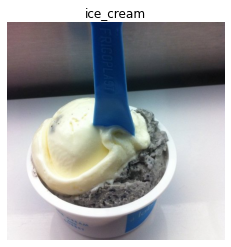

In [27]:
view_random_image('10_food_classes_all_data/train/','ice_cream')

Image shape: (340, 512, 3)


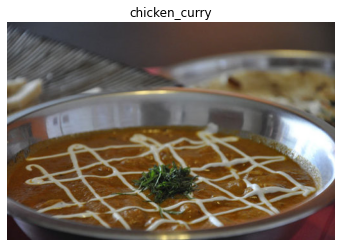

In [28]:
view_random_image('10_food_classes_all_data/train/','chicken_curry')

Image shape: (384, 512, 3)


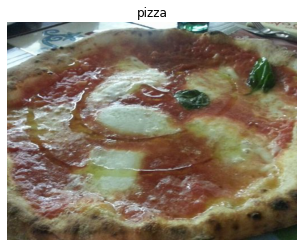

In [29]:
view_random_image('10_food_classes_all_data/train/',random.choice(class_names))

In [30]:
train_dir='10_food_classes_all_data/train/'
test_dir='10_food_classes_all_data/test/'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)
print('Training Images  :')
train_data=train_datagen.flow_from_directory(train_dir,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical',
                                             seed=7)
print('Testing Images  :')
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical',
                                           seed=7)

Training Images  :
Found 7500 images belonging to 10 classes.
Testing Images  :
Found 2500 images belonging to 10 classes.


In [31]:
import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name +'/'+ experiment_name + '/' + datetime.datetime.now().strftime('%d%m%Y-%H%M%S')
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard callback to {log_dir}')
  return tensorboard_callback

In [32]:
resnet_url='https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'
efficientnet_url='https://tfhub.dev/tensorflow/efficientnet/b0/classification/1'

In [33]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
def create_model(model_url,num_of_classes=10):
  feature_extraction_layer=hub.KerasLayer(model_url,
                                          trainable=False,
                                          input_shape=(224,224,3),
                                          name='feature_extraction_layer')
  model=tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(10,activation='softmax',name='output_layer')
  ])
  return model

In [34]:
efficientnet_model=create_model(efficientnet_url,10)

In [35]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1000)             5330564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 5,340,574
Trainable params: 10,010
Non-trainable params: 5,330,564
_________________________________________________________________


In [36]:
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [37]:
efficientnet_history=efficientnet_model.fit(train_data,
                                            epochs=5,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback('tensorflow_hub','efficientnet_b0')])

Saving Tensorboard callback to tensorflow_hub/efficientnet_b0/10122021-132400
Epoch 1/5
235/235 [==============================] - 72s 257ms/step - loss: 2.2367 - accuracy: 0.4699 - val_loss: 2.1627 - val_accuracy: 0.6396
Epoch 2/5
235/235 [==============================] - 59s 252ms/step - loss: 2.1111 - accuracy: 0.6155 - val_loss: 2.0342 - val_accuracy: 0.6880
Epoch 3/5
235/235 [==============================] - 59s 250ms/step - loss: 1.9957 - accuracy: 0.6376 - val_loss: 1.9163 - val_accuracy: 0.6904
Epoch 4/5
235/235 [==============================] - 59s 249ms/step - loss: 1.8905 - accuracy: 0.6389 - val_loss: 1.8098 - val_accuracy: 0.6880
Epoch 5/5
235/235 [==============================] - 59s 249ms/step - loss: 1.7961 - accuracy: 0.6401 - val_loss: 1.7147 - val_accuracy: 0.6904


In [38]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

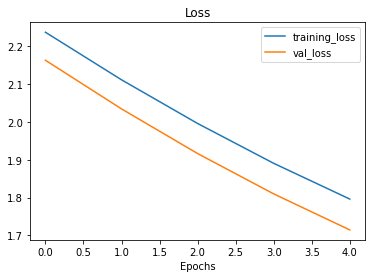

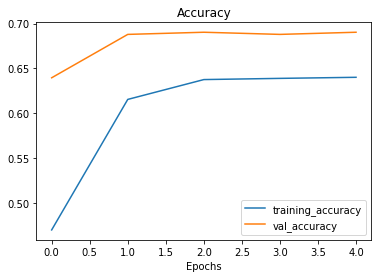

In [39]:
plot_loss_curves(efficientnet_history)

In [40]:
resnet_model=create_model(resnet_url,10)

In [41]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25615849  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 10,020
Non-trainable params: 25,615,849
_________________________________________________________________


In [42]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [43]:
resnet_history=resnet_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback('tensorflow_hub','resnet_V2_50')])

Saving Tensorboard callback to tensorflow_hub/resnet_V2_50/10122021-132913
Epoch 1/5
235/235 [==============================] - 77s 293ms/step - loss: 1.0370 - accuracy: 0.6808 - val_loss: 0.5794 - val_accuracy: 0.8068
Epoch 2/5
235/235 [==============================] - 67s 283ms/step - loss: 0.6307 - accuracy: 0.7924 - val_loss: 0.5308 - val_accuracy: 0.8240
Epoch 3/5
235/235 [==============================] - 66s 282ms/step - loss: 0.5527 - accuracy: 0.8171 - val_loss: 0.5319 - val_accuracy: 0.8212
Epoch 4/5
235/235 [==============================] - 66s 283ms/step - loss: 0.5088 - accuracy: 0.8305 - val_loss: 0.5141 - val_accuracy: 0.8332
Epoch 5/5
235/235 [==============================] - 67s 284ms/step - loss: 0.4709 - accuracy: 0.8455 - val_loss: 0.5127 - val_accuracy: 0.8240


In [44]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 17s 212ms/step - loss: 0.5127 - accuracy: 0.8240


[0.512669563293457, 0.8240000009536743]

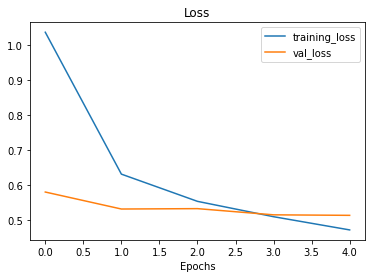

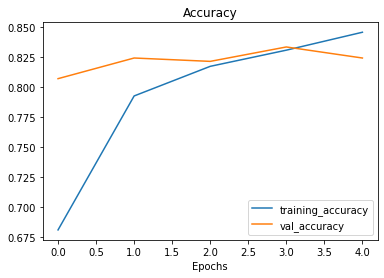

In [45]:
plot_loss_curves(resnet_history)